## Expand selected Twitter URLs with urlExpander
**Purpose**: 
- expand Twitter URLs which are shortened (e.g., by bit.ly)
- note: this project uses a [custom version of urlExpander](https://github.com/wlmwng/urlExpander):
    - the `expand()` is outputting many connection pool/client/server errors. To reduce them:
        - I added 5-10 second sleep time per request. (The package's multi-threading option is very efficient, but its speed can result in 4XX errors if it hits the same domains too quickly.)
        - added headers to the `requests.get()` call
    - added the response object's final destination `url`, `status_code`, and `reason` to the json cache file
- to check progress, `cd` to the output directory:
    - `wc -l urlexpander_modified.json` (number of URL entries in cache)
    - `tail -n 100 urlexpander_modified.json | grep [URL domain]` (show last n URL entries which include the URL domain)
    - `tail -n 100 urlexpander_modified.json | grep -v "\"response_code\": 2.*"` (show last n URL entries if their response codes were *not* 2XX; likely 4XX or 5XX)

In [1]:
import os
import datetime
import json
import pandas as pd
import plotnine as p9
import urlexpander
from mizani.breaks import date_breaks
from mizani.formatters import date_format


In [2]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '04-twitter-prep-urls-urlexpander', logger_type='main')

In [3]:
dir_fig = os.path.join("..", "..", "figures")
dir_url = os.path.join('..', '..', 'data', '02-intermediate', '02-twitter')
urls = pd.read_pickle(os.path.join(dir_url, f'politicians_tweeted_urls.pkl'))

In [5]:
urls['created_week'] = urls['created_at'].dt.to_period('W').dt.to_timestamp()
urls['created_month'] = urls['created_at'].dt.to_period('M').dt.to_timestamp()
urls['created_year'] = urls['created_at'].dt.to_period('Y').dt.to_timestamp()

In [ ]:
urls.head()

- expansion: more details in cache file and logs
    ```
    0%|          | 0/44 [00:00<?, ?it/s]
    There are 55349 links to unshorten
    100%|██████████| 44/44 [22:59:41<00:00, 1881.40s/it]
    ```
<br>

- to mark attempted URLs: 
    ```
    urls['urlexpander_attempted'] = urls['most_unrolled_url'].map(lambda x: urlexpander.is_short(x)
    ```
`

In [5]:
# LOGGER.info(f"started url expansion at {datetime.datetime.now()}")
# resolved_urls = urlexpander.expand(list(urls['most_unrolled_url']), 
#                                     chunksize=1280,
#                                     n_workers=6,
#                                     timeout=10,
#                                     cache_file=os.path.join(dir_url, 'urlexpander_modified.json'), 
#                                     verbose=1,
#                                     filter_function=urlexpander.url_utils.is_short) # only expand URLs if they are from recognized URL shorteners
# LOGGER.info(f"finished url expansion at {datetime.datetime.now()}")

In [ ]:
# urls['resolved_url'] = resolved_urls

In [28]:
# resolved_urls =  resolved_urls[['tweet_id', 'created_at', 'created_week', 'created_month',
#                                 'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
#                                 'url', 'expanded_url', 'display_url', 'unwound_url',
#                                 'most_unrolled_url', 'most_unrolled_field', 'is_dupe',
#                                 'is_from_tw', 'resolved_url']]

# resolved_urls.to_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_resolved.pkl'))

In [7]:
urls = pd.read_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_resolved.pkl'))

In [8]:
urls.columns

Index(['tweet_id', 'created_at', 'created_week', 'created_month',
       'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
       'url', 'expanded_url', 'display_url', 'unwound_url',
       'most_unrolled_url', 'most_unrolled_field', 'is_dupe', 'is_from_tw',
       'resolved_url'],
      dtype='object')

In [9]:
urls['resolved_netloc'] = urls['resolved_url'].map(lambda x: urlexpander.url_utils.standardize_url(url=x, 
                                                                                                   remove_scheme=True,
                                                                                                   replace_netloc_with_domain=False,
                                                                                                   remove_path=True,
                                                                                                   remove_query=True,
                                                                                                   remove_fragment=True,
                                                                                                   to_lowercase=True,))
urls['resolved_domain'] = urls['resolved_url'].map(lambda x: urlexpander.url_utils.get_domain(url=x))
urls['standardized_url'] = urls['resolved_url'].map(lambda x: urlexpander.url_utils.standardize_url(url=x))
urls['is_generic_url'] = urls['resolved_url'].map(lambda x: urlexpander.url_utils.is_generic_url(x))

In [10]:
def extract_error(resolved_url):
    if 'CLIENT_ERROR' in resolved_url:
        res = 'CLIENT_ERROR'
    elif 'CONNECTIONPOOL_ERROR' in resolved_url:
        res = 'CONNECTIONPOOL_ERROR'
    else:
        res = 'no error'
    return res

In [11]:
urls['urlexpander_error'] = urls['resolved_url'].map(lambda x: extract_error(x))

- export the URLs

In [12]:
urls = urls[['tweet_id', 'created_at', 'created_week', 'created_month',
       'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
       'url', 'expanded_url', 'display_url', 'unwound_url',
       'most_unrolled_url', 'most_unrolled_field', 'is_dupe',
       'is_from_tw', 'resolved_url', 'resolved_netloc', 'resolved_domain',
       'standardized_url', 'is_generic_url', 'urlexpander_error']]

urls.to_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_urlexpander.pkl'))

- spot-check the URLs

In [13]:
urls = pd.read_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_urlexpander.pkl'))

In [ ]:
# examples of generic URLs
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    display(
        urls.loc[urls["is_generic_url"]][
            [
                "most_unrolled_url",
                "resolved_url",
                "standardized_url",
                "is_generic_url",
            ]
        ].sample(n=100, random_state=42)
    )


In [15]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(urls[['resolved_url', 'standardized_url', 'is_generic_url']].sample(n=100, random_state=42))

,resolved_url,standardized_url,is_generic_url
179007,https://www.usatoday.com/story/opinion/2018/12/10/ryan-zinke-provides-bold-energetic-leadership-rob-bishop-editorials-debates/2270826002/,www.usatoday.com/story/opinion/2018/12/10/ryan-zinke-provides-bold-energetic-leadership-rob-bishop-editorials-debates/2270826002,False
225653,https://outreach.senate.gov/iqextranet/view_newsletter.aspx?id=102967&c=SenYoung,outreach.senate.gov/iqextranet/view_newsletter.aspx?c=senyoung&id=102967,False
146179,https://nyti.ms/2JSbu4X,nyti.ms/2jsbu4x,False
168114,https://comstock.house.gov/media-center/press-releases/update-federal-employee-pay-raise-issue,comstock.house.gov/media-center/press-releases/update-federal-employee-pay-raise-issue,False
186250,https://www.washingtonexaminer.com/news/congress/the-mysterious-case-of-aocs-scrubbed-green-new-deal-details?utm_source=2018+House+GOP+Staff+List&utm_campaign=62b5445d3c-EMAIL_CAMPAIGN_2019_01_29_06_11_COPY_01&utm_medium=email&utm_term=0_a8407dc016-62b5445d3c-147434657,www.washingtonexaminer.com/news/congress/the-mysterious-case-of-aocs-scrubbed-green-new-deal-details,False
121543,https://hudson.house.gov/press-releases/hudson-butterfield-bipartisan-ems-bill-heads-to-trumps-desk/,hudson.house.gov/press-releases/hudson-butterfield-bipartisan-ems-bill-heads-to-trumps-desk,False
25416,http://gop.gov/__CLIENT_ERROR__,gop.gov/__client_error__,False
229769,https://www.knopnews2.com/content/news/Sen-Deb-Fischer-staying-focused-on-seeing-Nebraskans-get-local-stations-on-DirecTV-567273131.html,www.knopnews2.com/content/news/sen-deb-fischer-staying-focused-on-seeing-nebraskans-get-local-stations-on-directv-567273131.html,False
217145,https://omaha.com/local/trump-s-rumored-pullout-from-open-skies-treaty-would-idle/article_751e95b7-ebf6-5100-81c9-259816c3b408.html,omaha.com/local/trump-s-rumored-pullout-from-open-skies-treaty-would-idle/article_751e95b7-ebf6-5100-81c9-259816c3b408.html,False
42396,https://vekeo.com/repwesterman/#event-16061,vekeo.com/repwesterman,False


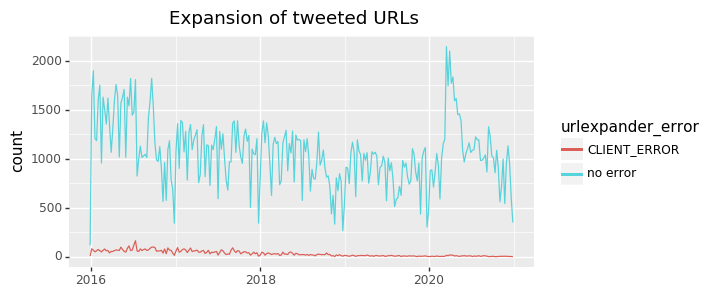

<ggplot: (8766598388209)>

In [16]:
plt = (p9.ggplot(urls, p9.aes(x='created_week'))
+ p9.geom_line(p9.aes(color='urlexpander_error'), stat='count')
+ p9.scale_x_datetime(name='',
                      breaks=date_breaks('2 years'),
                      labels=date_format('%Y'))
+ p9.theme(figure_size=(6,3),
           legend_position='right',
           subplots_adjust={'hspace':0.5})
+ p9.labs(title = f"Expansion of tweeted URLs"))

plt

In [14]:
# count of retrieved URLs per outlet by month from 2016 - 2020
# plt.save(os.path.join(dir_fig, 'c0204_urlExpander_timeline.svg'))